# Predict student's dropout and academic success 

By Jose Castillo

## Business Understanding

For this project we are looking to identify patterns between what makes a student graduate or dropout. We are going to look at several factors like economic backgroud, martial status, nacionality, and more. 

## Data Understanding 

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import tensorflow as tf

In [2]:
# import data

data = pd.read_csv('data/dataset.csv')

In [3]:
# Quick overview of the data

data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [5]:
data.columns = data.columns.str.lower()

## Data Preparation

In [6]:
# Selecting the columns I'll be working with

columns_new_df = ['marital status', 'course', 'daytime/evening attendance', 'displaced', 'debtor', 'tuition fees up to date',
                 'gender', 'scholarship holder', 'unemployment rate', 'gdp', 'target']

In [7]:
# New clean DF

df = data[columns_new_df].copy()

In [8]:
df.head()

,marital status,course,daytime/evening attendance,displaced,debtor,tuition fees up to date,gender,scholarship holder,unemployment rate,gdp,target
0,1,2,1,1,0,1,1,0,10.8,1.74,Dropout
1,1,11,1,1,0,0,1,0,13.9,0.79,Graduate
2,1,5,1,1,0,0,1,0,10.8,1.74,Dropout
3,1,15,1,1,0,1,0,0,9.4,-3.12,Graduate
4,2,3,0,0,0,1,0,0,13.9,0.79,Graduate


<AxesSubplot:>

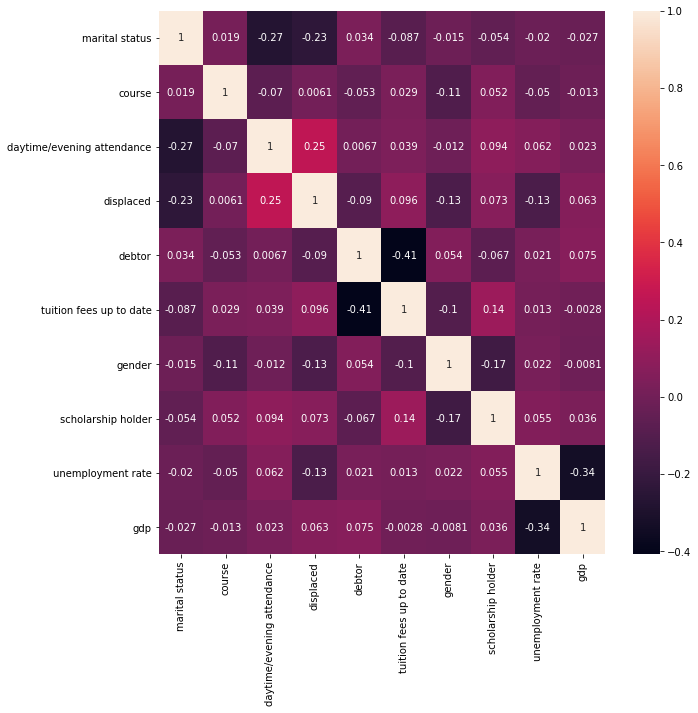

In [9]:
# Check for high correlation between features

plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot = True)

In [10]:
# All data types are int or float when in reality are categorical, we'll fix that

df['marital status'].replace({ 1 : 'Single', 2 : 'Married', 3 : 'Single', 4 : 'Divorced', \
                               5 : 'Single', 6 : 'Divorced'},
                         inplace=True)

df['course'].replace({ 1 : 'Biofuel Technologies', 2 : 'Animation', 3 : 'Social Service', 4 : 'Agronomy',
                        5 : 'Communication', 6 : 'Veterinary', 7 : "Informatics Engineering", 8 : "Equiniculture",
                        9 : "Management", 10 : "Social Service", 11 : "Tourism", 12 : "Nursing", 13 : "Oral Hygiene",
                        14 : "Marketing", 15 : "Journalism", 16 : "Basic Education", 17 : "Management"},
                       inplace=True)

df['gender'] = df['gender'].apply(lambda x: "Male" if x == 1 else "Female")

df['daytime/evening attendance'] = df['daytime/evening attendance'].apply(lambda x: "Daytime" if x == 1 else "Evening")

df['displaced'] = df['displaced'].apply(lambda x: "Displaced" if x == 1 else "Not displaced")

df['debtor'] = df['debtor'].apply(lambda x: "Debtor" if x == 1 else "No debt")

df['tuition fees up to date'] = df['tuition fees up to date'].apply(lambda x: "Behind payments" if x == 1 else "Up-to-date payments")

df['scholarship holder'] = df['scholarship holder'].apply(lambda x: "Scholarship" if x == 1 else "No scholarship")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   marital status              4424 non-null   object 
 1   course                      4424 non-null   object 
 2   daytime/evening attendance  4424 non-null   object 
 3   displaced                   4424 non-null   object 
 4   debtor                      4424 non-null   object 
 5   tuition fees up to date     4424 non-null   object 
 6   gender                      4424 non-null   object 
 7   scholarship holder          4424 non-null   object 
 8   unemployment rate           4424 non-null   float64
 9   gdp                         4424 non-null   float64
 10  target                      4424 non-null   object 
dtypes: float64(2), object(9)
memory usage: 380.3+ KB


### Pre-processing

In [12]:
# Since our model is trying to predict wether the student will graduate or not, we are going to drop students currently enrolled

df1 = df[df['target'] != 'Enrolled']

In [13]:
# Separate the categorical and numerical columns

categorical_cols = ['marital status', 'course', 'daytime/evening attendance', 'displaced', 'debtor', 'tuition fees up to date',
                   'gender', 'scholarship holder']
numerical_cols = ['unemployment rate', 'gdp']

In [14]:
# OneHotEncoder to our categorical values and Scale our numerical values

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

In [15]:
X = df1.drop('target', axis=1)
y = df1['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## Modeling

Since Our model is looking to predict wether the student will graduate or dropout we are going to drop the currently enrolled students

#### Logistic Regression

In [16]:
log_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [17]:
log_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['marital status', 'course',
                                                   'daytime/evening attendance',
                                                   'displaced', 'debtor',
                                                   'tuition fees up to date',
                                                   'gender',
                                                   'scholarship holder']),
                                                 ('num', StandardScaler(),
                                                  ['unemployment rate',
                                                   'gdp'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [18]:
y_pred_log = log_reg.predict(X_test)

In [19]:
accuracy = accuracy_score(y_test, y_pred_log)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.7589531680440771


#### Rand Forest

In [20]:
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [21]:
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['marital status', 'course',
                                                   'daytime/evening attendance',
                                                   'displaced', 'debtor',
                                                   'tuition fees up to date',
                                                   'gender',
                                                   'scholarship holder']),
                                                 ('num', StandardScaler(),
                                                  ['unemployment rate',
                                                   'gdp'])])),
                ('classifier', RandomForestClassifier())])

In [22]:
y_pred_rf = rf.predict(X_test)

In [23]:
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.7534435261707989


#### KNN

In [24]:
knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [25]:
knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['marital status', 'course',
                                                   'daytime/evening attendance',
                                                   'displaced', 'debtor',
                                                   'tuition fees up to date',
                                                   'gender',
                                                   'scholarship holder']),
                                                 ('num', StandardScaler(),
                                                  ['unemployment rate',
                                                   'gdp'])])),
                ('classifier', KNeighborsClassifier())])

In [26]:
y_pred_knn = knn.predict(X_test)

In [27]:
accuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.7272727272727273


#### Gradient Boosting

In [28]:
gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

In [29]:
gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['marital status', 'course',
                                                   'daytime/evening attendance',
                                                   'displaced', 'debtor',
                                                   'tuition fees up to date',
                                                   'gender',
                                                   'scholarship holder']),
                                                 ('num', StandardScaler(),
                                                  ['unemployment rate',
                                                   'gdp'])])),
                ('classifier', GradientBoostingClassifier())])

In [30]:
y_pred_gb = gb.predict(X_test)

In [31]:
accuracy = accuracy_score(y_test, y_pred_gb)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.7548209366391184


## Neural Network Model

In [60]:
data1 = data[data['target'] != "Enrolled"]

In [71]:
data1['target'] = data1['target'].apply(lambda x: 1 if x == 'Graduate' else 0)

<ipython-input-71-c102e49605da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['target'] = data1['target'].apply(lambda x: 1 if x == 'Graduate' else 0)


In [73]:
X = data1.drop('target', axis=1)
y = data1['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [74]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=10, activation='relu', input_shape=(34, )))
model.add(tf.keras.layers.Dense(units=10, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [75]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [76]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
91/91 [==============================] - 0s 1ms/step - loss: 1.4020 - accuracy: 0.6260
Epoch 2/100
91/91 [==============================] - 0s 1ms/step - loss: 0.4524 - accuracy: 0.7992
Epoch 3/100
91/91 [==============================] - 0s 1ms/step - loss: 0.4029 - accuracy: 0.8254
Epoch 4/100
91/91 [==============================] - 0s 1ms/step - loss: 0.3744 - accuracy: 0.8388
Epoch 5/100
91/91 [==============================] - 0s 1ms/step - loss: 0.3453 - accuracy: 0.8571
Epoch 6/100
91/91 [==============================] - 0s 1ms/step - loss: 0.3295 - accuracy: 0.8650
Epoch 7/100
91/91 [==============================] - 0s 1ms/step - loss: 0.3065 - accuracy: 0.8774
Epoch 8/100
91/91 [==============================] - 0s 1ms/step - loss: 0.2900 - accuracy: 0.8853
Epoch 9/100
91/91 [==============================] - 0s 1ms/step - loss: 0.2818 - accuracy: 0.8915
Epoch 10/100
91/91 [==============================] - 0s 1ms/step - loss: 0.2724 - accuracy: 0.8915
Epoch 11/

91/91 [==============================] - 0s 1ms/step - loss: 0.2047 - accuracy: 0.9232
Epoch 83/100
91/91 [==============================] - 0s 1ms/step - loss: 0.2098 - accuracy: 0.9184
Epoch 84/100
91/91 [==============================] - 0s 1ms/step - loss: 0.2023 - accuracy: 0.9270
Epoch 85/100
91/91 [==============================] - 0s 1ms/step - loss: 0.2025 - accuracy: 0.9242
Epoch 86/100
91/91 [==============================] - 0s 924us/step - loss: 0.2025 - accuracy: 0.9232
Epoch 87/100
91/91 [==============================] - 0s 921us/step - loss: 0.2056 - accuracy: 0.9194
Epoch 88/100
91/91 [==============================] - 0s 1ms/step - loss: 0.2022 - accuracy: 0.9242
Epoch 89/100
91/91 [==============================] - 0s 1ms/step - loss: 0.2010 - accuracy: 0.9270
Epoch 90/100
91/91 [==============================] - 0s 1ms/step - loss: 0.2009 - accuracy: 0.9267
Epoch 91/100
91/91 [==============================] - 0s 980us/step - loss: 0.2023 - accuracy: 0.9211
Epoch 9

In [77]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy: {}".format(test_accuracy))

23/23 [==============================] - 0s 1ms/step - loss: 0.2544 - accuracy: 0.9091
Test Accuracy: 0.9090909361839294


In [81]:
y_pred = model.predict(X_test)

In [82]:
y_pred_class = (y_pred > 0.5).astype(int)

In [83]:
cm = confusion_matrix(y_test, y_pred_class)

In [85]:
cm

array([[202,  47],
       [ 19, 458]], dtype=int64)